In [1]:
import pandas as pd
import seaborn as sns
import glob
import os
import janitor
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA

Text(0.5, 1.0, 'Fengyun-2D - Brouwer Mean Motion')

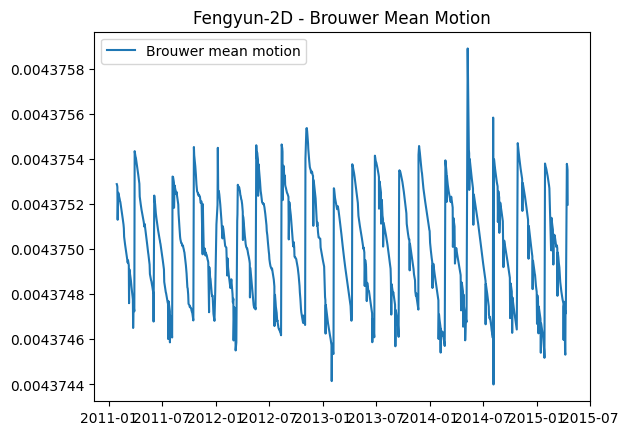

In [3]:
# Location to the file containing the csv file for the data
csv_file_path = "satellite_data/orbital_elements/unpropagated_elements_Fengyun-2D.csv"

# Reading the csv data file and creating a dataframe
df = pd.read_csv(csv_file_path, index_col = 0, parse_dates = True)

# Creating a dataframe with only the Brouwer Mean Motion
df_bmm = df[["Brouwer mean motion"]]

# Plotting the Brouwer Mean Motion
sns.lineplot(data = df_bmm)
plt.title("Fengyun-2D - Brouwer Mean Motion")

In [4]:
# File path to maneuver file
maneuver_file_path = 'satellite_data/manoeuvres/manFY2D.txt.fy'

data = []

# Reading the file data into the list
with open(maneuver_file_path, 'r') as file:
    for line in file:
        # Splitting the line by space
        parts = line.strip().split('"')
        #maneuver_type, satellite_id = parts[0].strip().split()[:2]
        start_date = parts[1]
        #end_time = parts[3]
        data.append(start_date)

# Defining the column names
column_names = ['Start_Date']

# Creating a dataframe with the text file data
df = pd.DataFrame(data, columns = column_names)

# Converting start and end maneuvers to datetime
df['Start_Date'] = pd.to_datetime(df['Start_Date'])

# Checking the dataframe
print(df.head())

           Start_Date
0 2015-04-10 15:30:00
1 2015-01-27 14:30:00
2 2014-10-24 15:30:00
3 2014-08-04 15:30:00
4 2014-05-09 15:30:00


/var/folders/5m/f9w6_kb12kn6r38z9rjzgfk00000gn/T/ipykernel_5384/2644158969.py:23: FutureWarning: Parsed string "2015-04-10T15:30:00 CST" included an un-recognized timezone "CST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['Start_Date'] = pd.to_datetime(df['Start_Date'])


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

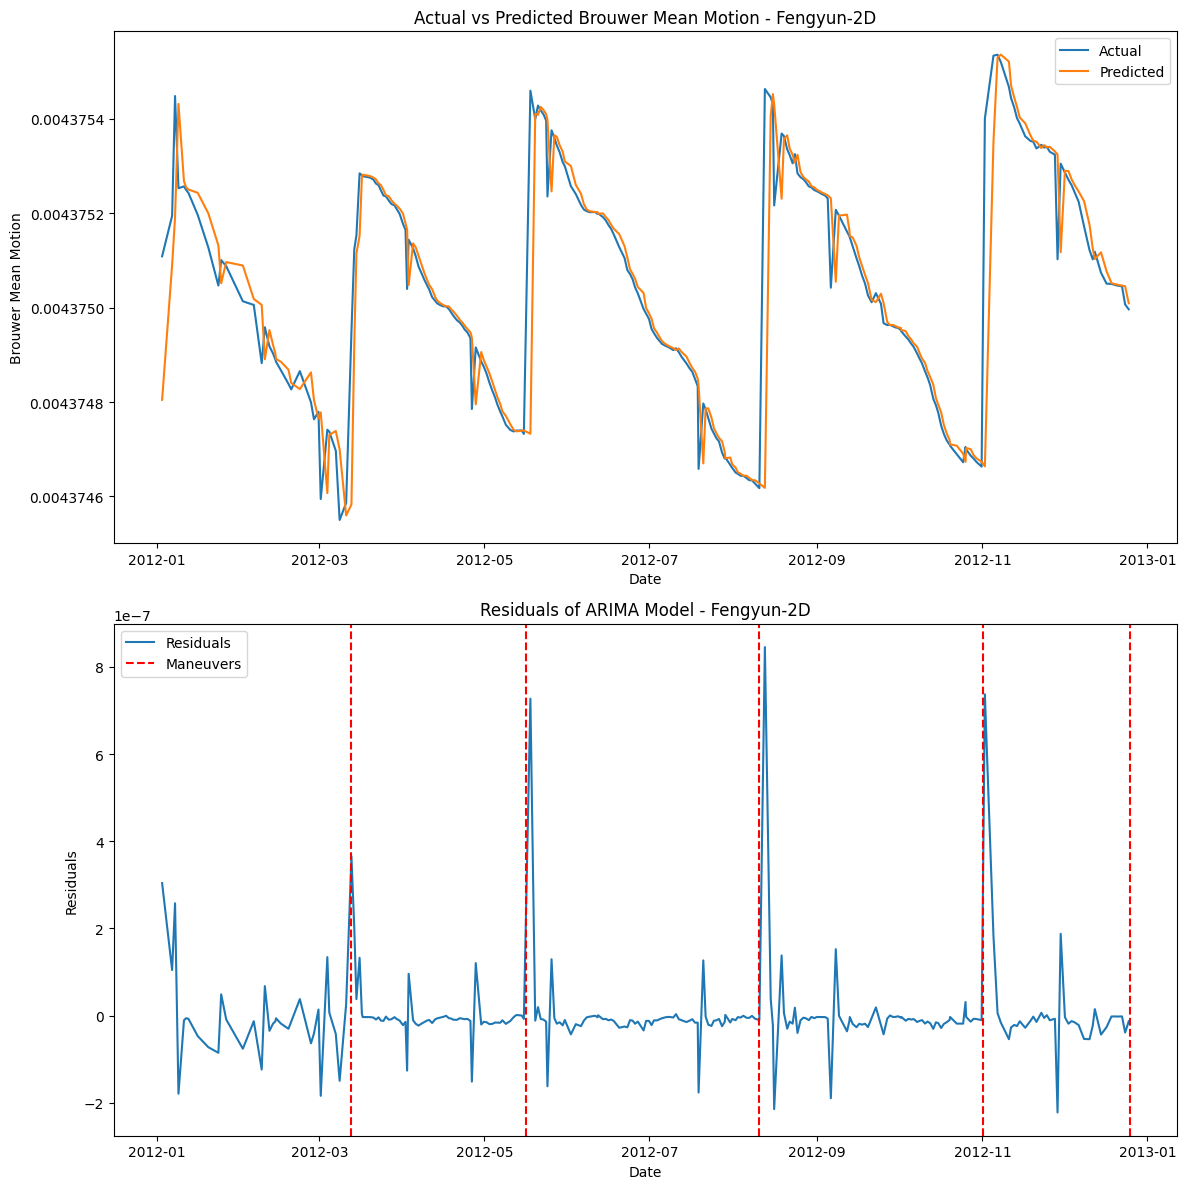

In [5]:
# Fitting an ARIMA model to the entire dataset
arima_model = ARIMA(df_bmm,order = (1,1,0))
arima_model_fit = arima_model.fit()

# Making predictions
predictions = arima_model_fit.predict(start = 0, end = len(df_bmm) - 1, typ = 'levels')

# Calculating residuals
residuals = df_bmm['Brouwer mean motion'] - predictions

# Defining date ranges
start_date = pd.to_datetime("2012-01-01")
end_date = pd.to_datetime("2012-12-31")

# Filtering the actual, predictions and residuals based on the date range
actual_filtered = df_bmm[start_date:end_date]
predictions_filtered = predictions[start_date:end_date]
residuals_filtered = residuals[start_date:end_date]

# Creating subplots
fig, axes = plt.subplots(2, 1, figsize = (12,12))

# Plotting actual vs predicted values
sns.lineplot(x = actual_filtered.index, y = actual_filtered["Brouwer mean motion"], label = "Actual", ax = axes[0])
sns.lineplot(x = predictions_filtered.index, y = predictions_filtered, label = "Predicted", ax = axes[0])
axes[0].set_title("Actual vs Predicted Brouwer Mean Motion - Fengyun-2D")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Brouwer Mean Motion")
axes[0].legend()

# Plotting residuals
sns.lineplot(x = residuals_filtered.index, y = residuals_filtered, label = "Residuals", ax = axes[1])
axes[1].set_title("Residuals of ARIMA Model - Fengyun-2D")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Residuals")

# Filtering maneuvers based on the date range
maneuvers_filtered = df[df["Start_Date"] >= start_date]
maneuvers_filtered = maneuvers_filtered[maneuvers_filtered["Start_Date"] <= end_date]

# Marking maneuvers on the residuals plot
maneuver_dates = maneuvers_filtered['Start_Date']
first_label = True
for maneuver_date in maneuver_dates:
    if first_label:
        axes[1].axvline(x = maneuver_date, color = 'red', linestyle = '--', label = "Maneuvers")
        first_label = False
    else:
        axes[1].axvline(x = maneuver_date, color = 'red', linestyle = '--')     
axes[1].legend()

plt.tight_layout()
plt.show()